## Generate the datasets

In [1]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility (optional)
np.random.seed(42)

# Number of rows
n = 5000

# Generate normally distributed values for P1, P2, and P3
P1 = np.random.normal(loc=0, scale=1, size=n)
P2 = np.random.normal(loc=0, scale=1, size=n)
P3 = np.random.normal(loc=0, scale=1, size=n)
P4 = np.random.normal(loc=0, scale=1, size=n)


# Compute F as the given polynomial function
# F = 34.23 * (P1 ** 3) + 12.34 * (P2 ** 4) + 3.53 * (P2 * P3)
F = P1 + 2*P2*P3 + 3*P3*P3 + 4*P4

# Create a DataFrame
df = pd.DataFrame({
    'P1': P1,
    'P2': P2,
    'P3': P3,
    "P4": P4,
    'F': F
})

# Save to CSV
df.to_csv('F1_data.csv', index=False)

print(f"CSV file 'polynomial_data.csv' successfully created with {n} rows.")

CSV file 'polynomial_data.csv' successfully created with 5000 rows.


In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
import pandas as pd
import time
from tqdm import tqdm

pd.set_option("display.max_columns", 200)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device : {device}")

Using device : cuda


In [3]:
df = pd.read_csv("/kaggle/working/F1_data.csv", header = None)
df = df.drop(index = 0)
df = df.astype(float)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 1 to 5000
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       5000 non-null   float64
 1   1       5000 non-null   float64
 2   2       5000 non-null   float64
 3   3       5000 non-null   float64
 4   4       5000 non-null   float64
dtypes: float64(5)
memory usage: 195.4 KB


In [5]:
y = torch.tensor(df.iloc[0:, 4].values, dtype = torch.float).unsqueeze(1)
X = torch.tensor(df.iloc[:,0:4].values, dtype = torch.float)

X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = 0.2, random_state = 42)

# Standardize inputs using training statistics
X_mean, X_std = X_train.mean(dim=0, keepdim=True), X_train.std(dim=0, keepdim=True)
X_train_std = (X_train - X_mean) / X_std
X_val_std = (X_val - X_mean) / X_std

# Standardize outputs (helps numerical stability)
y_mean, y_std = y_train.mean(), y_train.std()
y_train_std = (y_train - y_mean) / y_std
y_val_std = (y_val - y_mean) / y_std


train_ds = TensorDataset(X_train_std, y_train_std)
val_ds = TensorDataset(X_val_std, y_val_std)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(val_ds, batch_size = batch_size, shuffle = True)

print(f"Training samples : {len(train_ds)} | Validation Samples: {len(val_ds)}")

Training samples : 4000 | Validation Samples: 1000


In [6]:
class SingleNN(nn.Module):
    def __init__(self, input_dim = 4, hidden_dim = 10, num_layer = 3, output_dim = 1, dropout = 0.1):
        super(SingleNN, self).__init__()
        self.net = nn.Sequential(nn.Linear(input_dim, hidden_dim),\
                                 nn.SiLU(),\
                                 nn.Linear(hidden_dim, 15),\
                                 nn.SiLU(),\
                                 nn.Linear(15, hidden_dim),\
                                 nn.SiLU(),\
                                 nn.Linear(hidden_dim, output_dim))

    def forward(self, x):
        return self.net(x)


In [7]:
model = SingleNN().to(device)
print(f"Model with {sum(p.numel() for p in model.parameters())} Parameters")

Model with 386 Parameters


In [8]:
criterion  = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
epochs = 15
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr = 0.05,
    epochs = epochs,
    steps_per_epoch = len(train_loader)
)

In [9]:
start_time = time.time()
for epoch in range(epochs):
    model.train()
    train_loss, train_total = 0.0, 0
    loops = tqdm(train_loader, desc = f"Epoch {epoch+1}/{epochs}", unit = "batch")
    for xb, yb in loops:
        xb,yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out,yb)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item() * xb.size(0)
        train_total += yb.size(0)

    model.eval()
    val_loss, val_total = 0.0,0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_loss += criterion(preds,yb).item() * xb.size(0)
            val_total += yb.size(0)

    print(f"Epoch [{epoch+1}/{epochs}]"\
          f"Train loss: {train_loss/train_total:.4f} | "\
          f"Val loss: {val_loss/val_total:.4f}")
end_time = time.time()
print(f"\nTraining completed in {(end_time-start_time)/60:.2f} minutes")

Epoch 1/15: 100%|██████████| 125/125 [00:00<00:00, 130.33batch/s]


Epoch [1/15]Train loss: 0.7330 | Val loss: 0.4834


Epoch 2/15: 100%|██████████| 125/125 [00:00<00:00, 557.63batch/s]


Epoch [2/15]Train loss: 0.0675 | Val loss: 0.0113


Epoch 3/15: 100%|██████████| 125/125 [00:00<00:00, 552.41batch/s]


Epoch [3/15]Train loss: 0.0081 | Val loss: 0.0127


Epoch 4/15: 100%|██████████| 125/125 [00:00<00:00, 497.46batch/s]


Epoch [4/15]Train loss: 0.0106 | Val loss: 0.0062


Epoch 5/15: 100%|██████████| 125/125 [00:00<00:00, 547.63batch/s]


Epoch [5/15]Train loss: 0.0364 | Val loss: 0.0040


Epoch 6/15: 100%|██████████| 125/125 [00:00<00:00, 555.88batch/s]


Epoch [6/15]Train loss: 0.0062 | Val loss: 0.0077


Epoch 7/15: 100%|██████████| 125/125 [00:00<00:00, 551.88batch/s]


Epoch [7/15]Train loss: 0.0065 | Val loss: 0.0486


Epoch 8/15: 100%|██████████| 125/125 [00:00<00:00, 560.93batch/s]


Epoch [8/15]Train loss: 0.0210 | Val loss: 0.0041


Epoch 9/15: 100%|██████████| 125/125 [00:00<00:00, 562.89batch/s]


Epoch [9/15]Train loss: 0.0043 | Val loss: 0.0029


Epoch 10/15: 100%|██████████| 125/125 [00:00<00:00, 556.72batch/s]


Epoch [10/15]Train loss: 0.0016 | Val loss: 0.0020


Epoch 11/15: 100%|██████████| 125/125 [00:00<00:00, 552.42batch/s]


Epoch [11/15]Train loss: 0.0006 | Val loss: 0.0005


Epoch 12/15: 100%|██████████| 125/125 [00:00<00:00, 555.72batch/s]


Epoch [12/15]Train loss: 0.0003 | Val loss: 0.0004


Epoch 13/15: 100%|██████████| 125/125 [00:00<00:00, 551.27batch/s]


Epoch [13/15]Train loss: 0.0002 | Val loss: 0.0003


Epoch 14/15: 100%|██████████| 125/125 [00:00<00:00, 558.96batch/s]


Epoch [14/15]Train loss: 0.0002 | Val loss: 0.0003


Epoch 15/15: 100%|██████████| 125/125 [00:00<00:00, 562.85batch/s]

Epoch [15/15]Train loss: 0.0001 | Val loss: 0.0003

Training completed in 0.07 minutes


In [10]:
torch.save(model, "F1_model_full.pth")

In [11]:
for name, param in model.named_parameters():
    if "weight" in name:
        print(f"\n{name} shape: {param.shape}")
        print(param)  # raw tensor


net.0.weight shape: torch.Size([10, 4])
Parameter containing:
tensor([[-0.1695, -0.0803,  0.0691, -0.7310],
        [ 0.0117, -0.1313, -0.3944,  0.4012],
        [-0.1066, -0.6089,  0.1251, -0.3019],
        [ 0.0587,  0.3605,  1.1918,  0.2485],
        [ 0.0565, -0.3356, -1.0508,  0.2321],
        [ 0.2140, -0.0122, -0.0523,  0.7695],
        [ 0.0610, -0.1414, -0.4985,  0.2478],
        [-0.1178,  0.4932, -0.1381, -0.3885],
        [-0.0375,  0.0551,  0.0058, -0.2415],
        [ 0.0227, -0.3113, -0.9912,  0.0239]], device='cuda:0',
       requires_grad=True)

net.2.weight shape: torch.Size([15, 10])
Parameter containing:
tensor([[ 8.0562e-02,  5.8592e-02, -7.5069e-02,  7.9262e-01,  1.1141e-01,
         -8.1750e-02,  3.9037e-01,  4.1796e-04, -1.5750e-01,  5.3767e-01],
        [ 8.5854e-02, -3.3446e-01, -6.1867e-02,  9.6084e-01,  4.9944e-01,
         -7.3963e-01,  1.7371e-01, -1.0542e-01, -4.7196e-03,  7.4962e-01],
        [-3.2264e-01,  2.8956e-01, -3.7121e-01,  9.9175e-01,  8.2238e-

In [12]:
model.eval()
val_loss = 0.0
val_total = 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        val_loss += criterion(preds,yb).item() * xb.size(0)
        val_total += yb.size(0)
print(f'\nOriginal Model loss: {100 * val_loss / val_total:.5f}')


Original Model loss: 0.02771


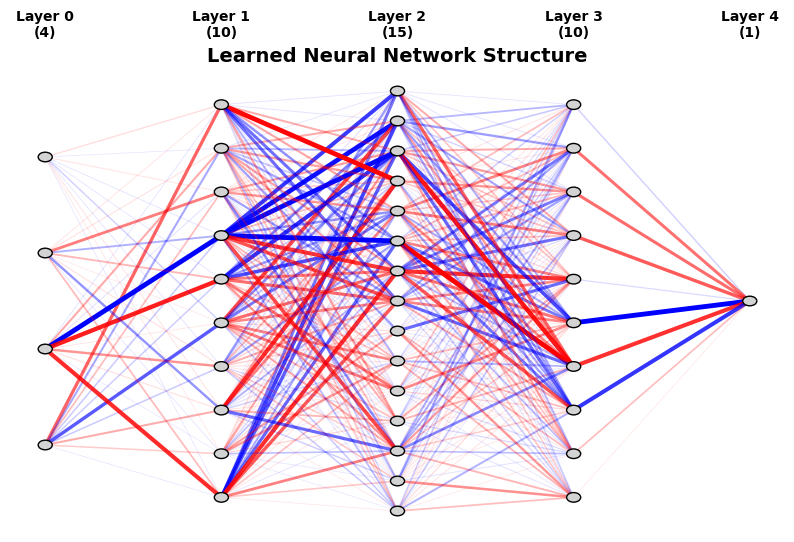

In [13]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def visualize_trained_network(model, max_nodes_per_layer=200):
    """
    Visualize a fully-connected feedforward network from its learned weights.
    Colors represent sign (red=negative, blue=positive),
    and edge width represents magnitude.
    
    Args:
        model: torch.nn.Module with nn.Linear layers
        max_nodes_per_layer: limit nodes for clarity in large layers
    """
    layers = [module for module in model.modules() if isinstance(module, torch.nn.Linear)]
    n_layers = len(layers) + 1
    layer_sizes = [layers[0].in_features] + [l.out_features for l in layers]

    # Normalize node count for drawing clarity
    display_sizes = [min(s, max_nodes_per_layer) for s in layer_sizes]
    
    # Setup figure
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    ax.set_title("Learned Neural Network Structure", fontsize=14, weight='bold')

    # Position nodes
    layer_positions = []
    x_spacing = 1 / (len(display_sizes) - 1)
    for i, n_nodes in enumerate(display_sizes):
        y_spacing = 1 / (n_nodes + 1)
        layer_positions.append([(i * x_spacing, 1 - (j + 1) * y_spacing) for j in range(n_nodes)])
    
    # Draw edges
    for i, layer in enumerate(layers):
        W = layer.weight.data.cpu().numpy()
        # Clip large layers for clarity if truncated
        W = W[:display_sizes[i+1], :display_sizes[i]]
        
        max_w = np.max(np.abs(W)) + 1e-8
        for out_idx, out_pos in enumerate(layer_positions[i+1]):
            for in_idx, in_pos in enumerate(layer_positions[i]):
                w = W[out_idx, in_idx]
                color = 'blue' if w > 0 else 'red'
                alpha = np.clip(abs(w) / max_w, 0.1, 1.0)
                lw = 0.5 + 3 * abs(w) / max_w
                ax.plot([in_pos[0], out_pos[0]], [in_pos[1], out_pos[1]],
                        color=color, alpha=alpha, linewidth=lw, zorder=1)

    # Draw nodes
    for layer in layer_positions:
        for (x, y) in layer:
            circle = plt.Circle((x, y), 0.01, color='lightgray', ec='k', zorder=3)
            ax.add_artist(circle)

    # Annotate layers
    for i, size in enumerate(layer_sizes):
        ax.text(i * x_spacing, 1.05, f"Layer {i}\n({size})",
                ha='center', fontsize=10, weight='bold')

    plt.show()

# Example usage:
visualize_trained_network(model)